<a href="https://colab.research.google.com/github/kaifcode2003/Real-Estate-Price-Prediction-Geospatial-Analysis/blob/main/Advanced_House_Price_Prediction_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import datetime
from geopy.distance import geodesic

In [12]:
# --- 1. Data Generation ---
# Part A: Base house data
np.random.seed(42)
locations = ['Koregaon Park', 'Hinjewadi', 'Wakad', 'Kothrud', 'Viman Nagar', 'Baner']
data = {
    'location': np.random.choice(locations, 500),
    'sqft': np.random.randint(600, 2500, 500),
    'bedrooms': np.random.randint(1, 5, 500),
    'year_built': np.random.randint(1990, 2023, 500),
}
df = pd.DataFrame(data)

base_price_per_sqft = {
    'Koregaon Park': 12000, 'Hinjewadi': 6000, 'Wakad': 7000,
    'Kothrud': 9000, 'Viman Nagar': 8500, 'Baner': 8000
}
df['price'] = df.apply(
    lambda row: (base_price_per_sqft[row['location']] * row['sqft'] * (1 + 0.1 * row['bedrooms'])) * (1 + (row['year_built'] - 1990) / 40) + np.random.normal(0, 500000),
    axis=1
)
df['price_lakhs'] = df['price'] / 100000

# Part B: Static Geospatial Datasets (This replaces the need for live API calls)
# In a real project, I'd load these from separate CSV files.
location_coords_data = {
    'location': ['Koregaon Park', 'Hinjewadi', 'Wakad', 'Kothrud', 'Viman Nagar', 'Baner'],
    'lat': [18.536, 18.591, 18.61, 18.507, 18.56, 18.55],
    'lon': [73.89, 73.73, 73.77, 73.80, 73.91, 73.79]
}
location_coords_df = pd.DataFrame(location_coords_data)

schools_data = {'name': ['School_A', 'School_B', 'School_C', 'School_D'], 'lat': [18.54, 18.51, 18.59, 18.56], 'lon': [73.90, 73.81, 73.75, 73.80]}
schools_df = pd.DataFrame(schools_data)

metro_data = {'name': ['Metro_KP', 'Metro_Kothrud', 'Metro_Hinjewadi'], 'lat': [18.53, 18.50, 18.60], 'lon': [73.88, 73.81, 73.74]}
metro_df = pd.DataFrame(metro_data)

# Merge the coordinates into our main dataframe
df = pd.merge(df, location_coords_df, on='location', how='left')

print("--- Initial Dataset with Coordinates ---")
print(df.head())



--- Initial Dataset with Coordinates ---
      location  sqft  bedrooms  year_built         price  price_lakhs     lat  \
0      Kothrud  1912         1        2007  2.753917e+07   275.391664  18.507   
1  Viman Nagar  1877         3        1990  2.060348e+07   206.034763  18.560   
2        Wakad  2357         1        2003  2.473951e+07   247.395136  18.610   
3  Viman Nagar   956         2        1991  1.037371e+07   103.737079  18.560   
4  Viman Nagar   622         1        2017  9.755596e+06    97.555959  18.560   

     lon  
0  73.80  
1  73.91  
2  73.77  
3  73.91  
4  73.91  


In [13]:

# --- 2. Geospatial Feature Engineering ---
# This is where the project gets interesting. I'm calculating distances and proximity to amenities.
PUNE_DOWNTOWN_COORDS = (18.5195, 73.8553) # Pune Camp

def find_nearest_poi_dist(house_coords, poi_df):
    """Calculates the distance to the nearest Point of Interest (POI)."""
    distances = [geodesic(house_coords, (poi_lat, poi_lon)).km for poi_lat, poi_lon in zip(poi_df['lat'], poi_df['lon'])]
    return min(distances) if distances else None

def count_pois_within_radius(house_coords, poi_df, radius_km):
    """Counts how many POIs are within a given radius."""
    count = 0
    for poi_lat, poi_lon in zip(poi_df['lat'], poi_df['lon']):
        distance = geodesic(house_coords, (poi_lat, poi_lon)).km
        if distance <= radius_km:
            count += 1
    return count

print("\n--- Performing Geospatial Calculations... ---")
df['distance_to_downtown'] = df.apply(lambda row: geodesic((row['lat'], row['lon']), PUNE_DOWNTOWN_COORDS).km, axis=1)
df['distance_to_nearest_metro'] = df.apply(lambda row: find_nearest_poi_dist((row['lat'], row['lon']), metro_df), axis=1)
df['schools_within_2km'] = df.apply(lambda row: count_pois_within_radius((row['lat'], row['lon']), schools_df, 2), axis=1)

crime_rate_simulated = {'Koregaon Park': 0.8, 'Hinjewadi': 1.5, 'Wakad': 1.2, 'Kothrud': 0.9, 'Viman Nagar': 1.1, 'Baner': 1.0}
df['crime_rate_per_1000'] = df['location'].map(crime_rate_simulated)

print("\n--- Dataset After Geospatial Feature Engineering ---")
print(df[['location', 'distance_to_downtown', 'distance_to_nearest_metro', 'schools_within_2km']].head())


--- Performing Geospatial Calculations... ---

--- Dataset After Geospatial Feature Engineering ---
      location  distance_to_downtown  distance_to_nearest_metro  \
0      Kothrud              6.001043                   1.309757   
1  Viman Nagar              7.310787                   4.588882   
2        Wakad             13.469397                   3.354043   
3  Viman Nagar              7.310787                   4.588882   
4  Viman Nagar              7.310787                   4.588882   

   schools_within_2km  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0  


In [14]:
# --- 3. Standard Feature Engineering ---
current_year = datetime.datetime.now().year
df['house_age'] = current_year - df['year_built']



--- Starting Exploratory Data Analysis... ---


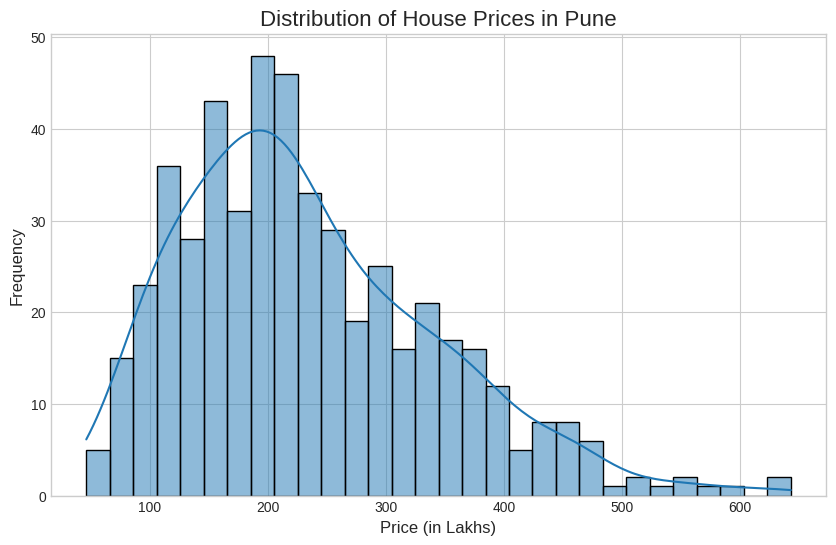

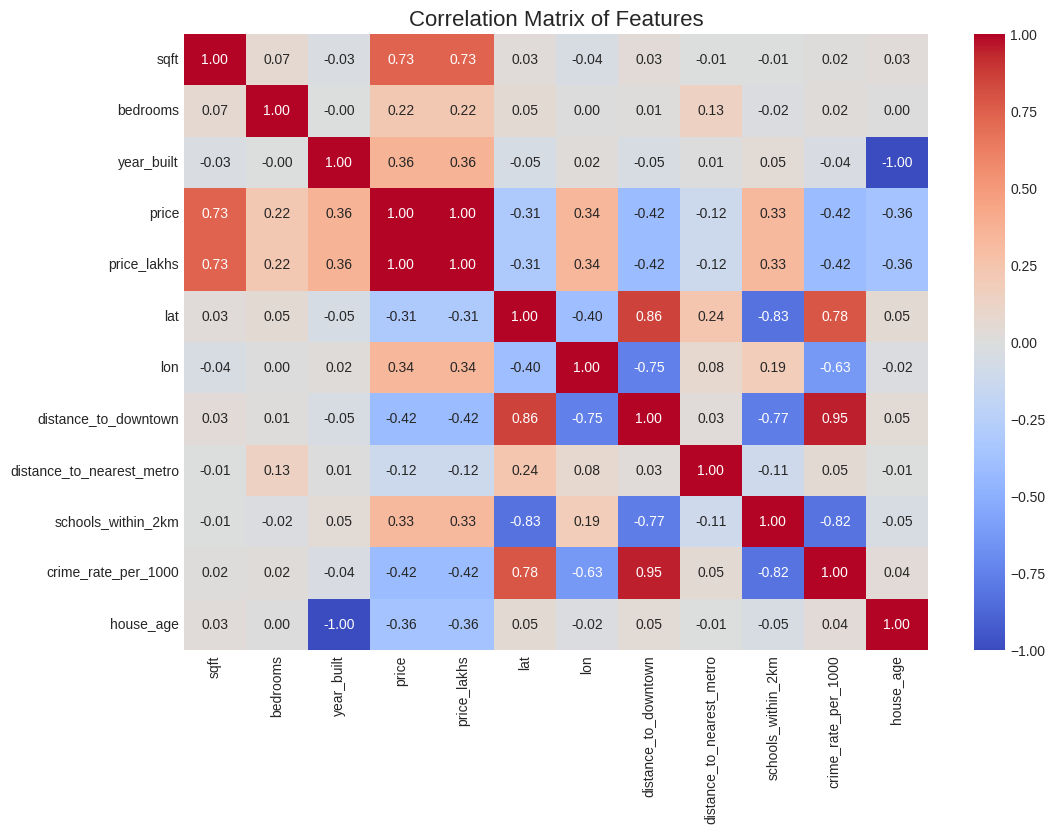

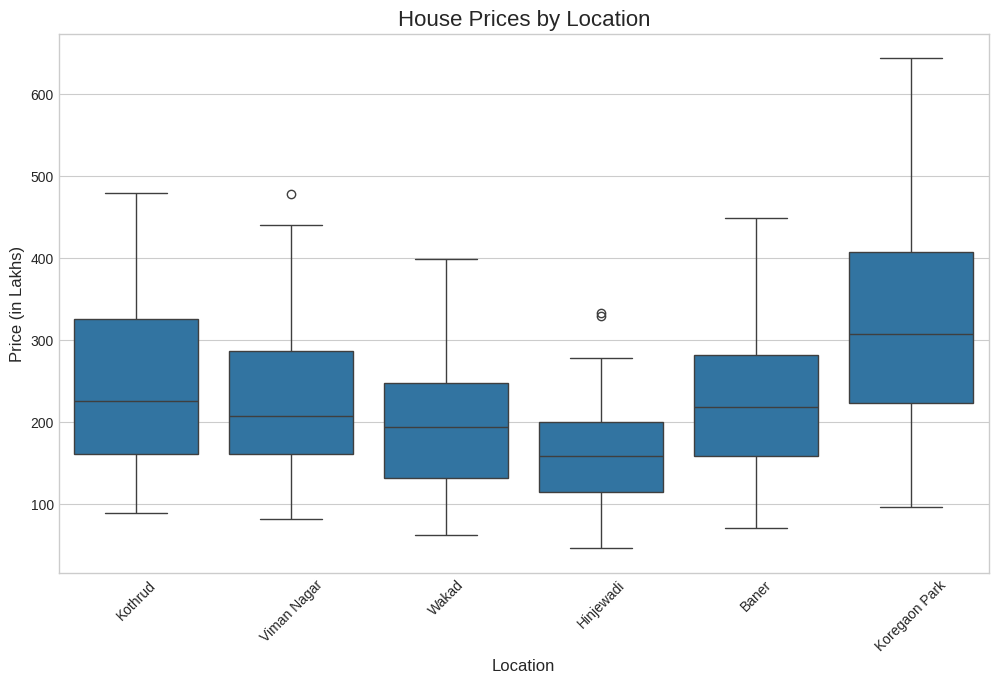

In [15]:


# --- 4. Exploratory Data Analysis (EDA) ---
# Before modeling, I want to explore the data to understand it better.
print("\n--- Starting Exploratory Data Analysis... ---")
plt.style.use('seaborn-v0_8-whitegrid')

# How is the price distributed?
plt.figure(figsize=(10, 6))
sns.histplot(df['price_lakhs'], kde=True, bins=30)
plt.title('Distribution of House Prices in Pune', fontsize=16)
plt.xlabel('Price (in Lakhs)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# How do the different numeric features relate to each other and the price?
plt.figure(figsize=(12, 8))
# Selecting only numeric columns for correlation
numeric_cols = df.select_dtypes(include=np.number)
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()

# How do prices vary by location?
plt.figure(figsize=(12, 7))
sns.boxplot(x='location', y='price_lakhs', data=df)
plt.title('House Prices by Location', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Price (in Lakhs)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [17]:
# --- 5. Data Preprocessing for Modeling ---
features = ['sqft', 'bedrooms', 'house_age', 'distance_to_downtown', 'crime_rate_per_1000', 'distance_to_nearest_metro', 'schools_within_2km', 'location']
target = 'price_lakhs'

X = df[features]
y = df[target]

numeric_features = ['sqft', 'bedrooms', 'house_age', 'distance_to_downtown', 'crime_rate_per_1000', 'distance_to_nearest_metro', 'schools_within_2km']
categorical_features = ['location']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [18]:

# --- 6. Model Training (Using Ridge Regression) ---
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge(alpha=1.0))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_pipeline.fit(X_train, y_train)


# --- 7. Model Evaluation ---
y_pred = ridge_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"\n--- Model Performance on Test Set ---")
print(f"R-squared (R2): {r2:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")



--- Model Performance on Test Set ---
R-squared (R2): 0.946
Mean Squared Error (MSE): 620.571


In [19]:
# --- 8. Coefficient Analysis & Interpretation ---
encoded_feature_names = ridge_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_feature_names)
coefficients = ridge_pipeline.named_steps['regressor'].coef_
coef_df = pd.DataFrame({'feature': all_feature_names, 'coefficient': coefficients}).sort_values(by='coefficient', ascending=False)

print("\n--- What Drives the Price? ---")
print(coef_df)



--- What Drives the Price? ---
                      feature  coefficient
0                        sqft    79.661048
9      location_Koregaon Park    32.431792
1                    bedrooms    20.747982
11       location_Viman Nagar     4.440736
8          location_Hinjewadi    -0.686369
6          schools_within_2km    -1.349089
12             location_Wakad    -3.083551
7              location_Baner    -6.434403
5   distance_to_nearest_metro   -12.895628
4         crime_rate_per_1000   -19.487220
3        distance_to_downtown   -24.106194
10           location_Kothrud   -26.668205
2                   house_age   -39.746210


/tmp/ipython-input-424107396.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=coef_df, palette='viridis')


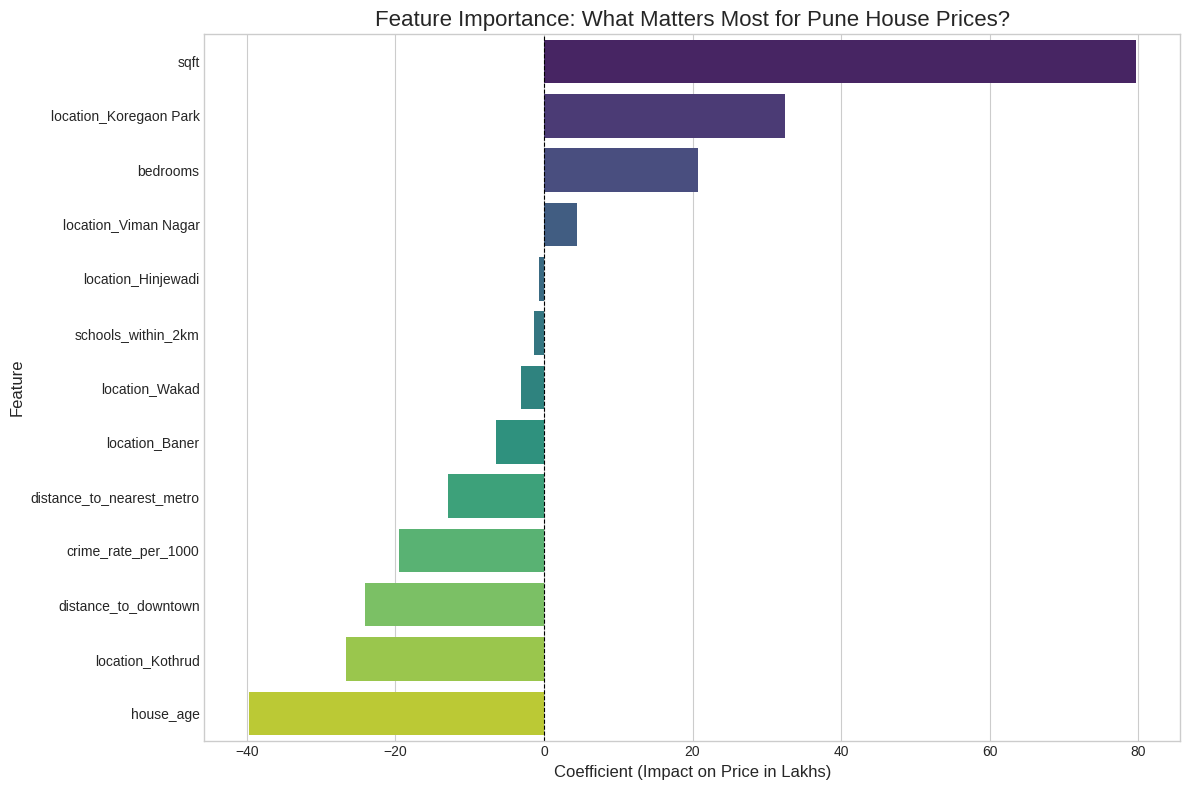

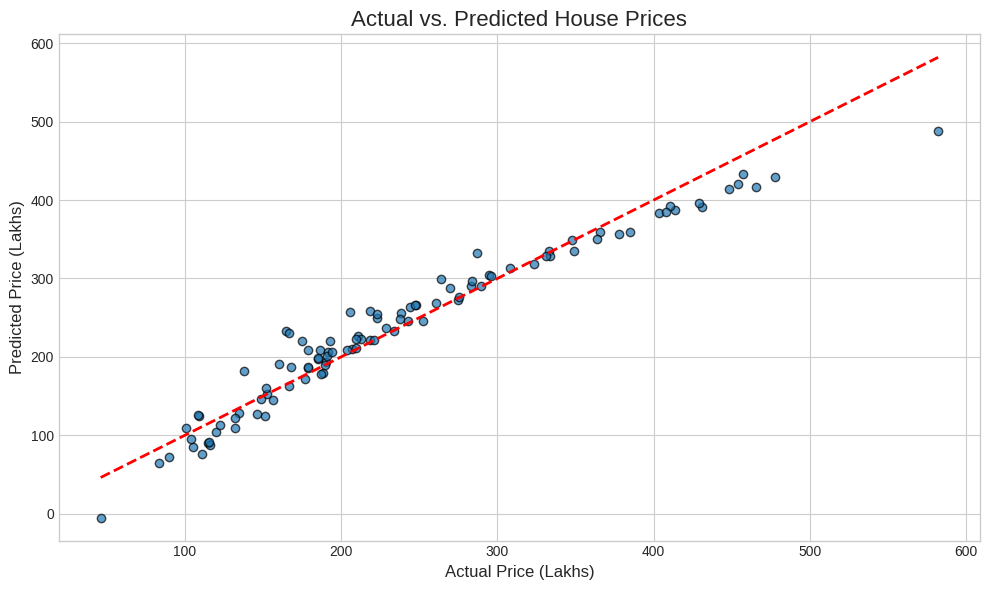

In [20]:
# --- 9. Final Visualizations ---
plt.figure(figsize=(12, 8))
sns.barplot(x='coefficient', y='feature', data=coef_df, palette='viridis')
plt.title('Feature Importance: What Matters Most for Pune House Prices?', fontsize=16)
plt.xlabel('Coefficient (Impact on Price in Lakhs)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted House Prices', fontsize=16)
plt.xlabel('Actual Price (Lakhs)', fontsize=12)
plt.ylabel('Predicted Price (Lakhs)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()